# Listening to LIGO auxiliary data

We will download some noise-monitoring data from LIGO and play it as a sound.

(The following two cells of code are preliminaries which you can skip.)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [78]:
from gwpy.timeseries import TimeSeries
import gwpy.time
import numpy as np
from IPython.display import Audio
from scipy.io.wavfile import write as write_wav

## Retrieving data

Let's download some auxiliary channel data from the Gravitational Wave Open Science Center (GWOSC), following the documentation [here](https://gwosc.org/O3/auxiliary/) and the example [here](https://git.ligo.org/gwosc/tutorials/gwosc-aux-tutorials/-/blob/main/Tutorials/data_access.ipynb).

To do that, we need to specify a **channel name** and a stretch of **time**. The term _channel_ refers to a specific data stream recorded by a given sensor or sensors, i.e., the channel name specifies which sensor/recorder we want (e.g., seismic motion, microphones, light sensors, magnetic fields, or even gravitational waves!).

The channel name we choose below (`L1:ISI-GND_STS_ITMY_Z_BLRMS_30M_100M`) corresponds to a seismometer located in the corner station near the inner test mass of the Y-arm of the LIGO Livingston instrument (`L1`). We can see that by looking up the channel name on the list of channels [here](https://git.ligo.org/gwosc/tutorials/gwosc-aux-tutorials/-/blob/main/Channels/O3_bulk_aux_channel_list.csv); additionally, we can map out channels by looking them up in [pem.ligo.org](https://pem.ligo.org), though the list of active channels evolves and you might not find all channels there.

In [4]:
channel_name = 'L1:ISI-GND_STS_ITMY_Z_BLRMS_30M_100M'

Time in LIGO land is specified in terms of the GPS coordinate system (see, e.g., [this reference](https://www.oc.nps.edu/oc2902w/gps/timsys.html)), which is the number of seconds since 1/5/1980 to 1/6/1980 midnight (a fractional number corresponds to a fraction of a second). To specify what data we want, we need to set start and end GPS times.

In [83]:
start_time = 1266624018
end_time = 1266624618 + 10*60*60

We can see what dates the chosen `start_time` and `end_time` correspond to using the `gwpy.time.from_gps` tool.

In [84]:
print("Start time:\t%s" % gwpy.time.from_gps(start_time).strftime('%Y-%m-%d %H:%M:%S'))
print("End time:\t%s" % gwpy.time.from_gps(end_time).strftime('%Y-%m-%d %H:%M:%S'))

Start time:	2020-02-25 00:00:00
End time:	2020-02-25 10:10:00


So the GPS times we specified above correspond to 10 minutes starting at 00:00 h UTC on February 25, 2020.

With all that info, we can download the data!

In [85]:
data = TimeSeries.fetch(channel_name, start=start_time, end=end_time, host='losc-nds.ligo.org')

## Plotting data

### Time series

Now that we have downloaded the data, we can display it in different ways. First, in the time domain: we can show what the recording was as a function of time.

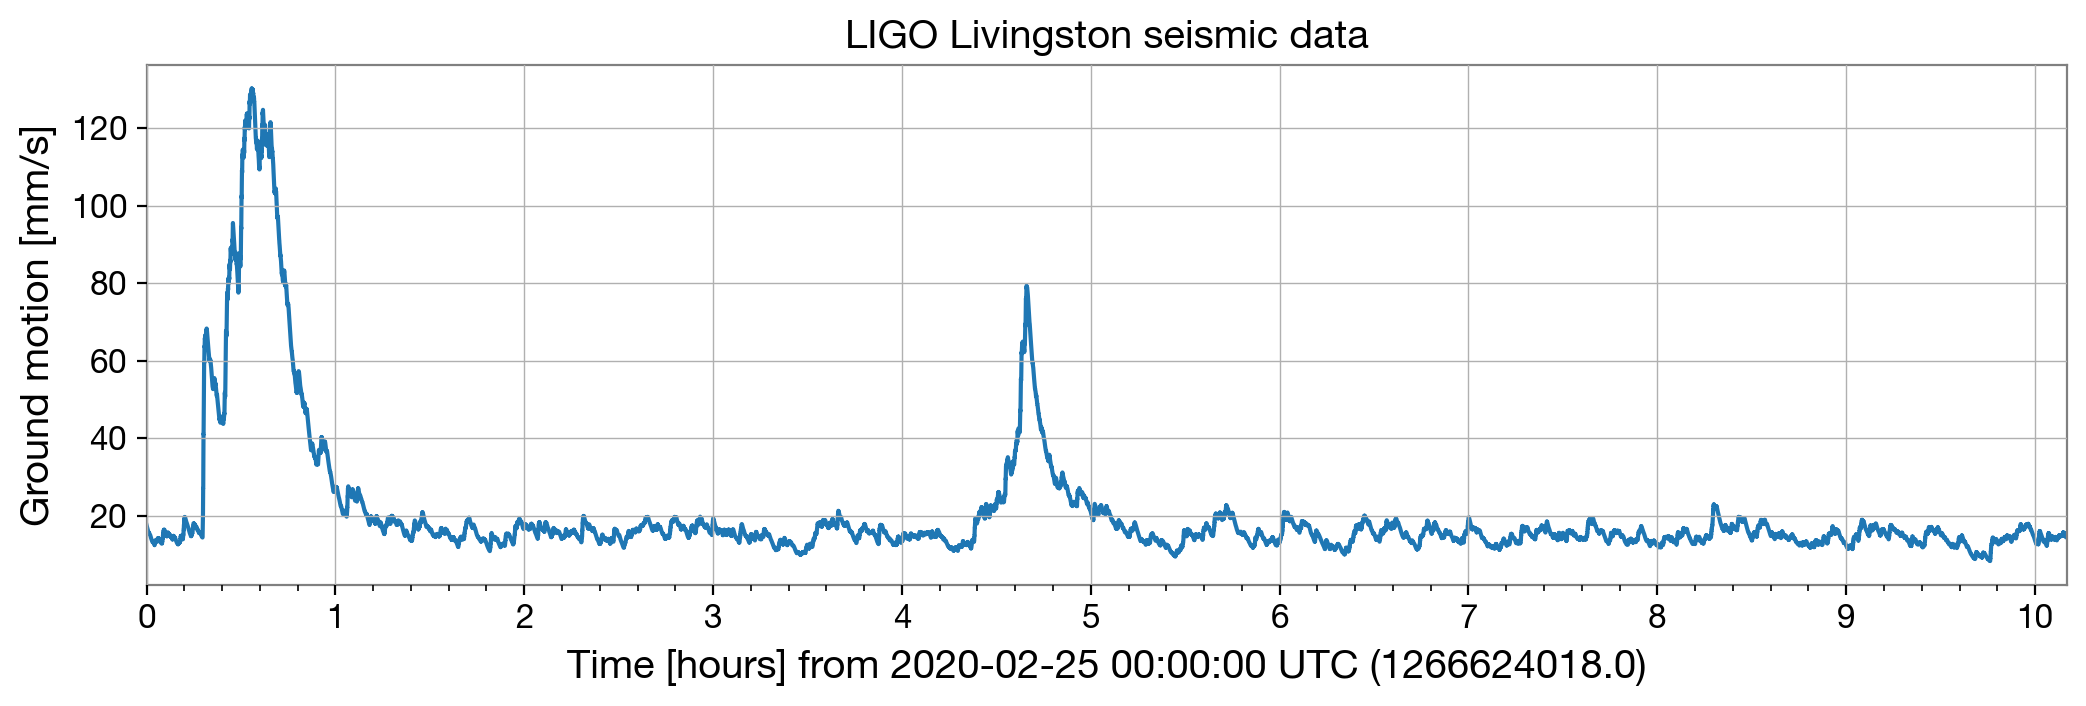

In [86]:
data.plot(ylabel="Ground motion [mm/s]", title="LIGO Livingston seismic data", epoch=start_time);

The ground motion decreases from midnight until ~2min later, then starts to rise again around 5 min from midnight. Note that the data record the instantaneous speed of ground motion and they are in units of millimeters per second.

NOTE: the time axis in the plot is labeled in reference to UTC time, which is a global time standard.

### Spectrum

We can look also at the same data in frequency space: is this noise white, blue (higher pitches) or red (lower pitches)?

To do that, we compute what is called an _amplitude spectral density_ (ASD), or spectrum, which tells us how loud each frequency contributes to the segment of data we have observed.

In [87]:
data_asd = data.asd(4, 2)

We can plot the ASD as a function of frequency to see visually whether high or low frequencies matter most.

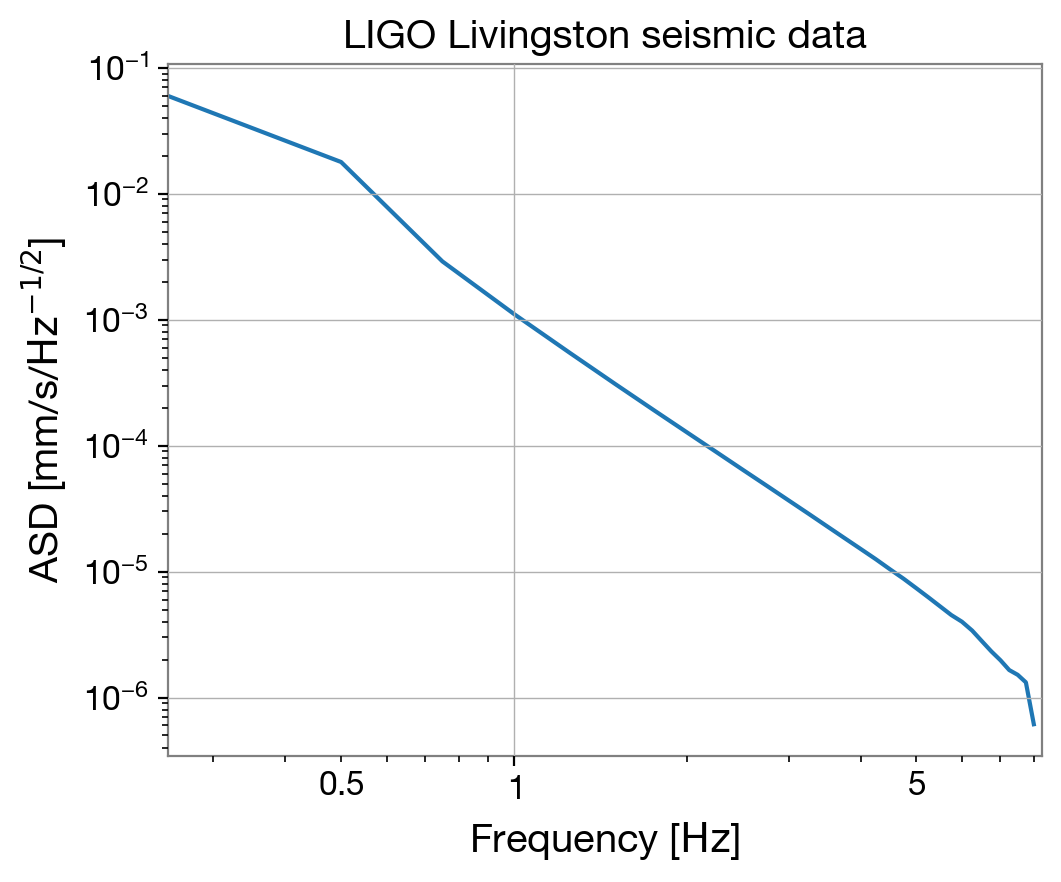

In [88]:
data_asd.plot(title="LIGO Livingston seismic data", ylabel=r"ASD [mm/s/$\mathrm{Hz}^{-1/2}$]");

These data are dominated by _low_ frequencies, below 1 Hz, which is what we expect for seismic data, since the ground usually shakes slowly. (Remember that 1 Hz means the oscillations are happening once per second; similarly, a lower frequency of 0.5 Hz means the oscillations happen once every two seconds---the higher the frequency the shorter the period.)

### Spectrogram

Finally, we may produce a _spectrogram_ which is a spectrum computed as a function of time. This allows us to see how the power at different frequencies evolves over time.

In [70]:
specgram = data.spectrogram(4) ** (1/2.)

We will plot it so that the color represents how "loud" a given frequency is at a given time: brighter colors means more power. The vertical axis will be frequency and the horizontal axis time.

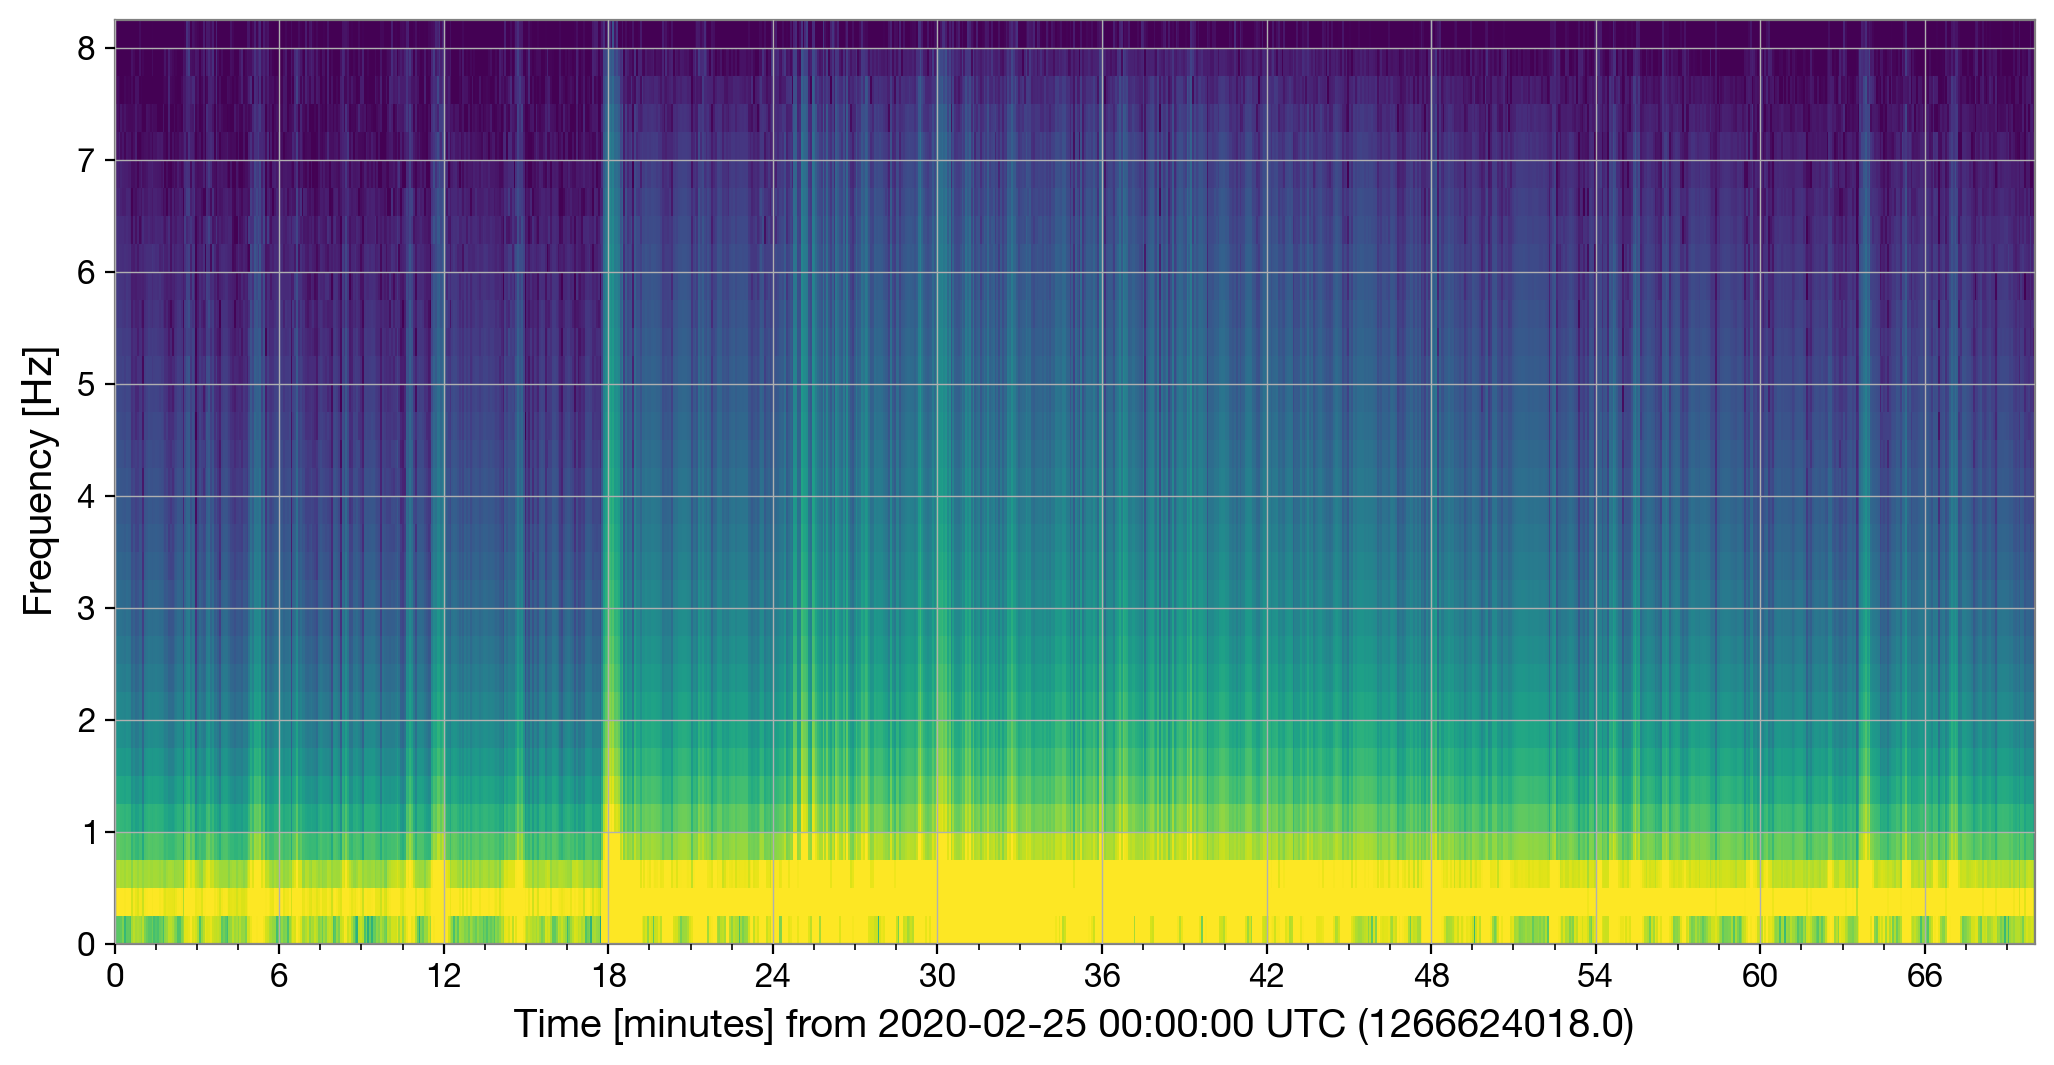

In [71]:
plot = specgram.imshow(norm='log', vmin=1e-6, vmax=0.5e-1);


Again, we see that at all times lower frequencies below 1 Hz dominate these data, with a bit of higher frequency noise (faster vibrations) at specific times (e.g., 5 minutes into this data segment).

## Play sound!

We will now play the above data as a sound. To make it easier to play, we will speed up the sampling rate by a huge factor of 2,756x.

We will also add a gain factor to make the sound louder; however, this will cause clipping of the sound at some points where the noise was loudest.

In [105]:
srate = int(data.sample_rate.value)

# Ensure the data is in int16 format for WAV. You might need to scale it appropriately.
d = np.log10(data.value)
scaled_data = np.int16(d/np.max(np.abs(d)) * 32767)

gain_factor = 10

audio_srate = 44100
print(f"Increasing srate by {audio_srate/srate:.2f}x from {srate} Hz to {audio_srate} Hz")

audio = Audio(data=scaled_data*gain_factor, rate=audio_srate)
display(audio)

Increasing srate by 2756.25x from 16 Hz to 44100 Hz


In [80]:
# Write to WAV file
write_wav("output.wav", audio_srate, scaled_data*gain_factor)